In [1]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import MobileNet
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Path of dataset
TRAIN_PATH = '/content/drive/MyDrive/Dataset/BanglaCurrency/Training'

In [4]:
takas = os.listdir(TRAIN_PATH)
takas = takas[0:]
print(takas)

['10', '1', '100', '500', '1000', '20', '5', '200', '2', '50']


In [5]:
# Data Preprocessing
image_size = (250, 120)
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1697 files belonging to 10 classes.
Using 1358 files for training.
Found 1697 files belonging to 10 classes.
Using 339 files for validation.


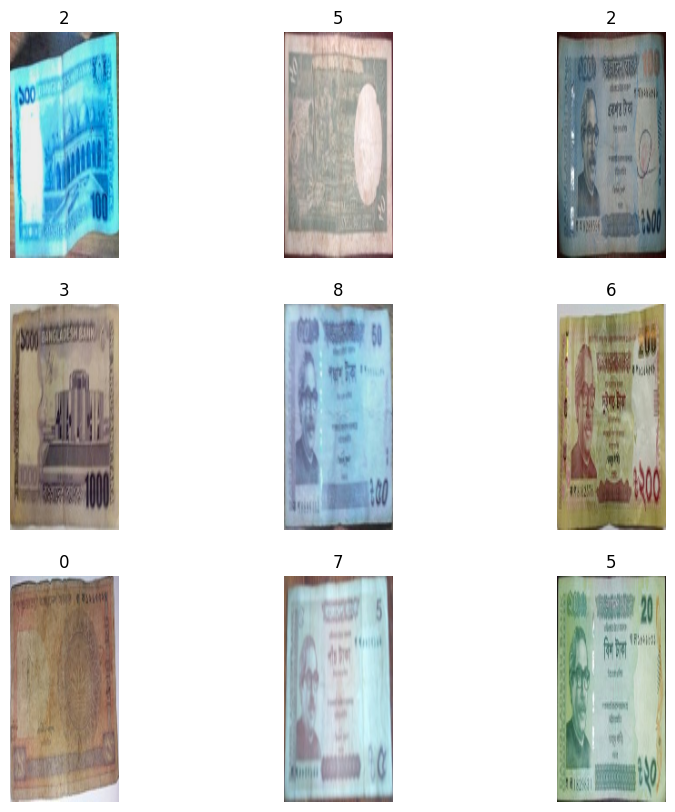

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

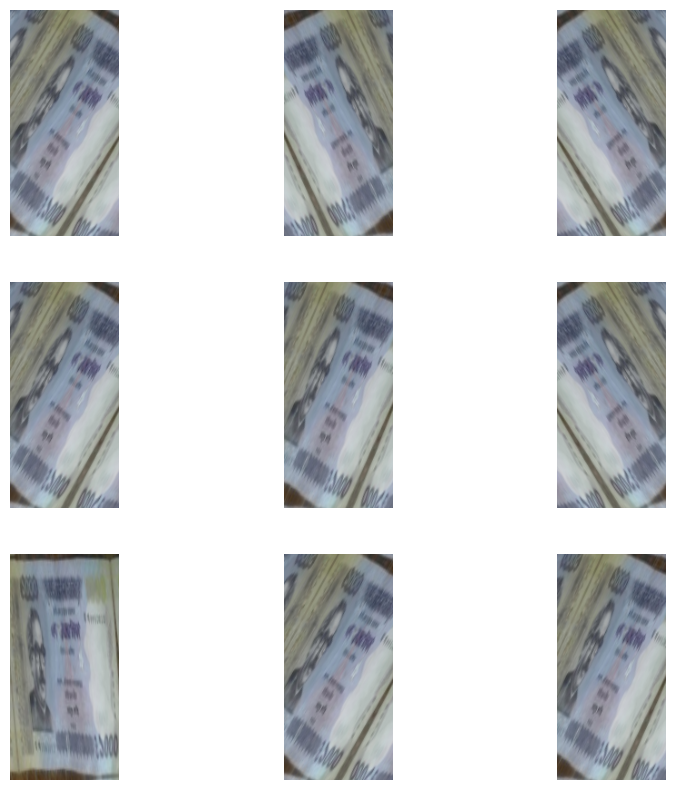

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [11]:
# Load MobileNet Model
IMAGE_SIZE = [250, 120]
mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in mobilenet.layers:
    layer.trainable = False

x = Flatten()(mobilenet.output)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=mobilenet.input, outputs=x)

<ipython-input-11-50fc4f9bff92>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 250, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 125, 60, 32)         │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 125, 60, 32)         │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 125, 60, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 125, 60, 32)         │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 125, 60, 32)         │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 125, 60, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 125, 60, 64)         │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 125, 60, 64)         │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 125, 60, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 126, 61, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 62, 30, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 62, 30, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 62, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 62, 30, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 62, 30, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 62, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 62, 30, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 62, 30, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 62, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 62, 30, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,443,914 (13.14 MB)

 Trainable params: 215,050 (840.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [13]:
# Train Model
epochs = 10
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 165s 15s/step - accuracy: 0.1680 - loss: 6.3230 - val_accuracy: 0.4307 - val_loss: 3.0617
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.4071 - loss: 2.8635 - val_accuracy: 0.5487 - val_loss: 1.8136
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5904 - loss: 1.4393 - val_accuracy: 0.6342 - val_loss: 1.2463
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6672 - loss: 1.0543 - val_accuracy: 0.6755 - val_loss: 1.0243
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7337 - loss: 0.8212 - val_accuracy: 0.6932 - val_loss: 0.9527
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7701 - loss: 0.6786 - val_accuracy: 0.7109 - val_loss: 0.9443
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7837 - loss: 0.6024 - val_accuracy: 0.7050 - val_loss: 0.9363
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7949 - loss: 0.6196 - val_accuracy: 0.7611 - val_los

In [14]:
# Save Model
model.save("/content/drive/MyDrive/dataset/saved_model/currency_recognition_model(mobileNet).h5")

In [15]:
# Evaluate Model
y_true = []
y_pred = []
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step


In [16]:
# Performance Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        16
           1       0.82      0.76      0.79        42
           2       0.88      0.92      0.90        53
           3       0.86      0.86      0.86        35
           4       0.85      0.78      0.82        37
           5       0.77      0.84      0.81        32
           6       1.00      1.00      1.00        13
           7       0.72      0.65      0.68        43
           8       0.60      0.73      0.66        37
           9       0.68      0.68      0.68        31

    accuracy                           0.78       339
   macro avg       0.80      0.79      0.79       339
weighted avg       0.79      0.78      0.78       339

Confusion Matrix:
[[10  0  0  0  0  1  0  1  4  0]
 [ 0 32  1  0  0  0  0  4  2  3]
 [ 0  0 49  0  0  0  0  0  2  2]
 [ 0  0  0 30  0  2  0  1  1  1]
 [ 0  0  1  0 29  4  0  1  1  1]
 [ 0  0  0  0  2 27  0  1  1  1]
 [

In [17]:
# Testing with a Sample Image
currency = ["1", "10", "100", "1000", "2", "20", "200", "5", "50", "500"]
img_path = "/content/drive/MyDrive/Dataset/BanglaCurrency/Testing/0.jpg"
img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print("Predicted Currency:", currency[predictions.argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Currency: 100


In [18]:
# Audio Feedback
from IPython.display import Audio
audio_files = {
    "1": "one.mp3", "2": "two.mp3", "5": "five.mp3", "10": "ten.mp3",
    "20": "twenty.mp3", "50": "fifty.mp3", "100": "onehundred.mp3",
    "200": "twohundred.mp3", "500": "fivehundred.mp3", "1000": "thousand.mp3"
}
if currency[predictions.argmax()] in audio_files:
    wn = Audio(f'/content/drive/MyDrive/Dataset/BanglaCurrency/Voice/{audio_files[currency[predictions.argmax()]]}', autoplay=True)
    display(wn)
else:
    print("Something went wrong!")